In [69]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import missingno as msno
from yellowbrick.cluster import KElbowVisualizer
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

In [70]:
df = pd.read_csv("data.csv", delimiter=',', encoding = "ISO-8859-1")

In [71]:
#Այս հատվածում մենք ուսւմնասրելու ենք data-ն

print(df.isnull().sum())
print()
print("Դատայի observation-ների չափը", df.shape[0])

#Մեր data-ի observation-ները 541909ն են և Նկատենք որ ունենք բացակայող տվյալներ

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Դատայի observation-ների չափը 541909


In [72]:
#Նկատենք որ ունենք 5 categorial և 3 numeric տվյալ
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [73]:
#Կատեգորիական տվյալների նկարագրությունը
df.describe(exclude=['float64','int64']).T

# Ունենք բացակայող տվյալներ


,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
InvoiceDate,541909,23260,10/31/2011 14:41,1114
Country,541909,38,United Kingdom,495478


In [74]:
#Թվային տվյալների նկարագրությունը
df.describe().T
#Նկատենք որ UnitPrice և Quantity feature ները չնայած որ պետք է պարունակեն միայն դրական տվյալներ, պարունակում են նաև բացասական տվյալներ։

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


Դատայի observation-ների չափը 541909


<Axes: >

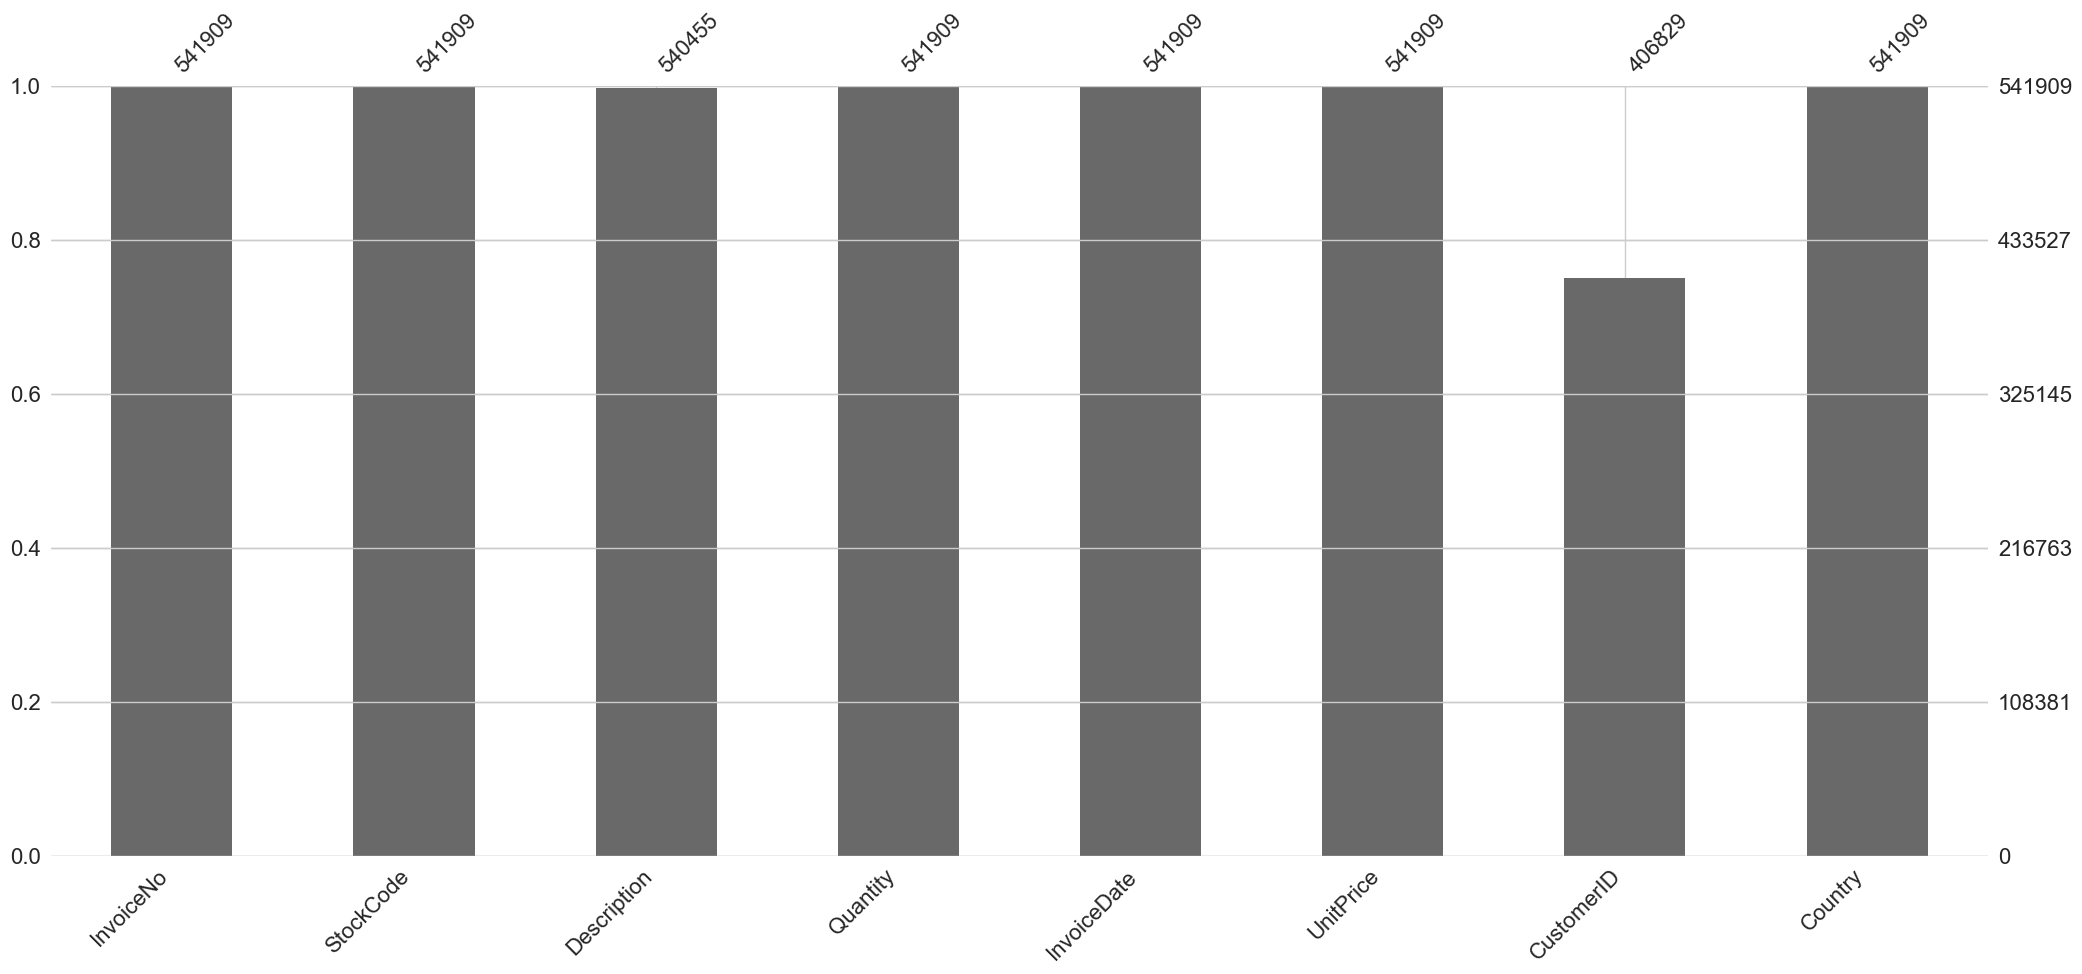

In [75]:
#Գծենք հիստոգրամ և հասկանանք բացակայող տվյալների հարաբերական տարբերությունը:

print("Դատայի observation-ների չափը", df.shape[0])
msno.bar(df)

<Axes: >

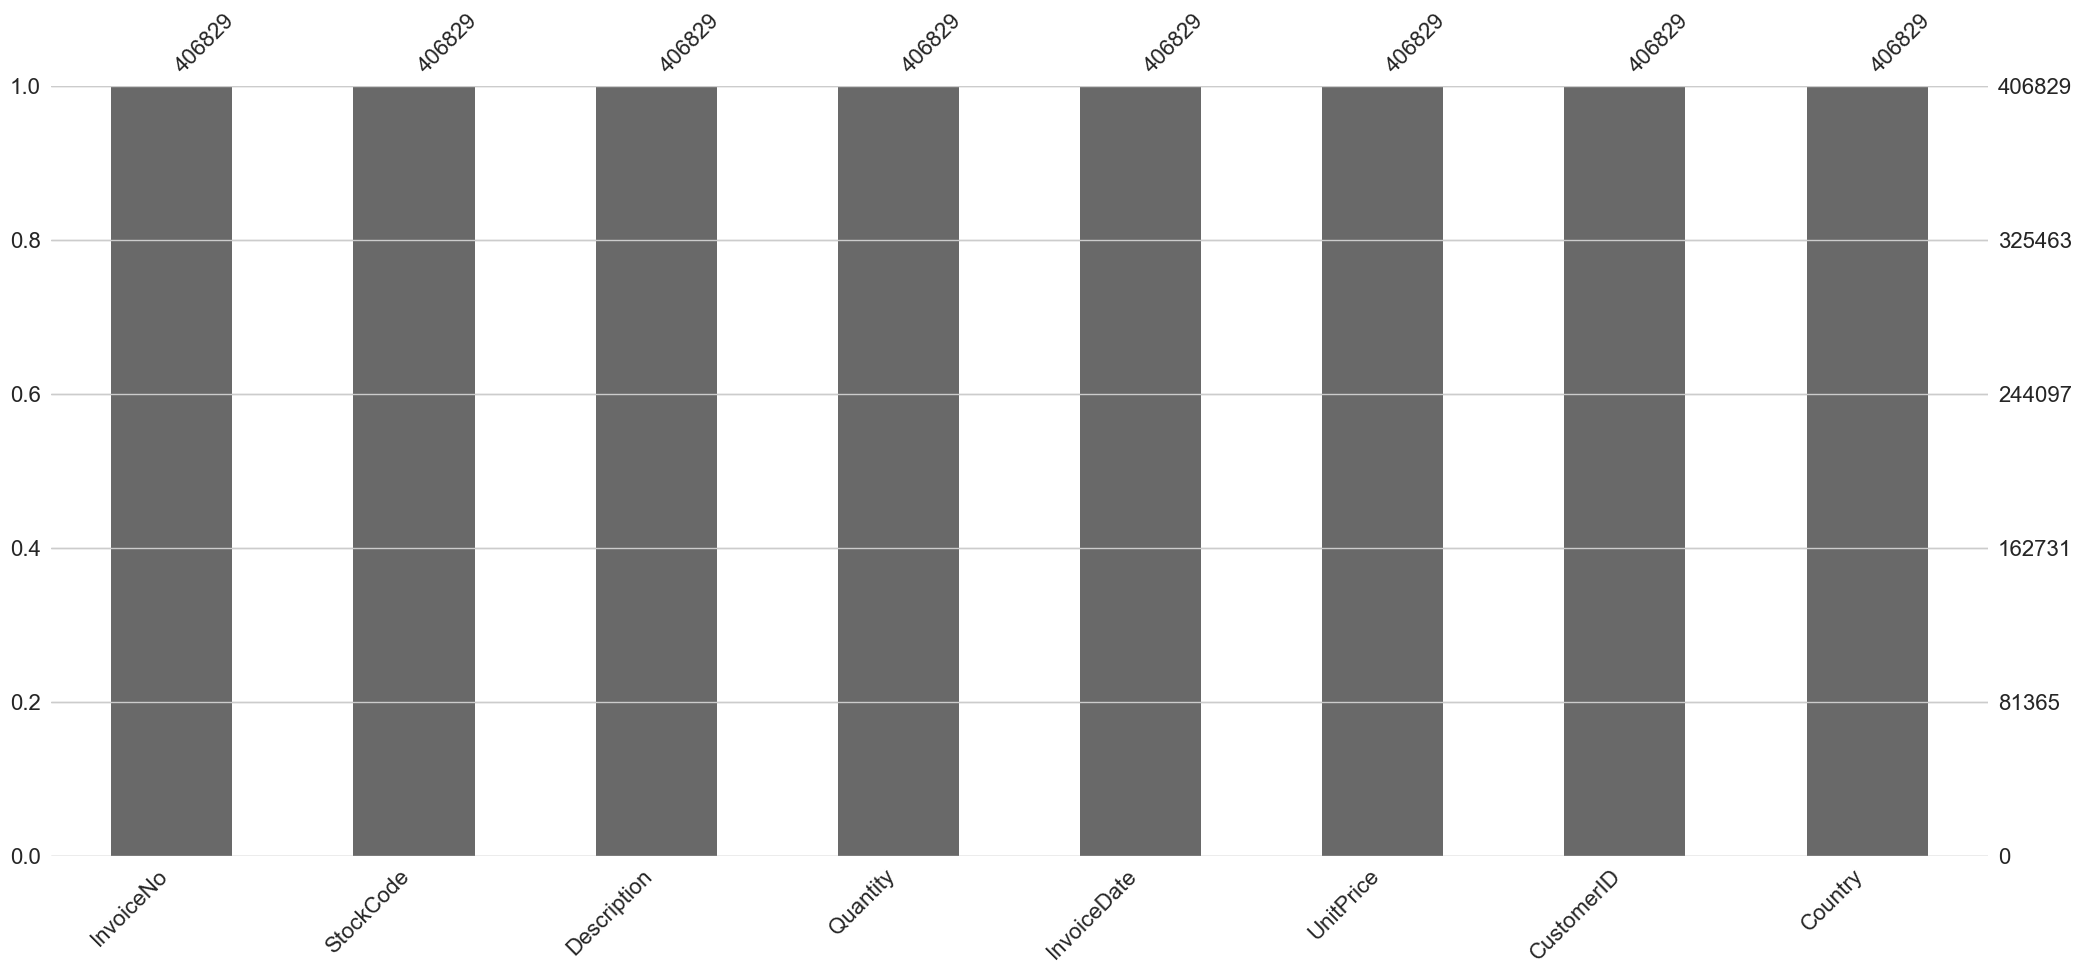

In [76]:
#Այժմ դեն նետենք բացակայող տվյալ պարունակող տողերը և համոզվենք որ էլ չունենք բացակաող տվյալ։
df.dropna(inplace =True)
msno.bar(df)

In [77]:
#Այժմ ազատվենք այն տողերից որոնք պետք է լինեն դրական բայց բացասական են։
df.drop(df[df['Quantity'] < 0].index, inplace = True)
df.drop(df[df['UnitPrice'] < 0].index, inplace = True)

#և համոզվենք որ ազատվել ենք
df[df['Quantity']<0].shape[0], df[df['UnitPrice']<0].shape[0]


(0, 0)

In [78]:
#Ձևախոխենք data-ն իր հետ ավելի հարմար աշխատելու համար
#Փոխարինենք Quantity և UnitPrice սյուները 1 նոր TotalAmount սյունով
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']
total_amount = df.groupby('CustomerID')['TotalAmount'].sum().reset_index()
total_amount

,CustomerID,TotalAmount
0,12346.0,77183.60
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40
...,...,...
4334,18280.0,180.60
4335,18281.0,80.82
4336,18282.0,178.05
4337,18283.0,2094.88


In [79]:
#Հաշվենք ամեն CustomerID համապատասխանող InvoiceNo-ի հաճախականությունը
customer_freq = df.groupby("CustomerID")['InvoiceNo'].count().reset_index()
customer_freq

,CustomerID,InvoiceNo
0,12346.0,1
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17
...,...,...
4334,18280.0,10
4335,18281.0,7
4336,18282.0,12
4337,18283.0,756


In [80]:
#Այժմ նոր սյուն ավելացնենք որը ցույց կտա վերջին կատարված Transaction-ը

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Last_transaction']=(df['InvoiceDate'].max()-df['InvoiceDate']).dt.days
last_transaciton = df.groupby(['CustomerID','Country'])['Last_transaction'].max().reset_index()

In [81]:
#Քանի որ StockCode սյունը, չի պարունակում մեր համար կարչոր ոչ մի ինֆորմացիյա
#անտեսենք այն և ըստ մեր նոր ստեղծած սյուները վերականգնենք մեր data-ն
merged = pd.merge(last_transaciton, customer_freq, how='inner', on = "CustomerID")
new_df = pd.merge(merged, total_amount, how='inner', on = 'CustomerID')
new_df

,CustomerID,Country,Last_transaction,InvoiceNo,TotalAmount
0,12346.0,United Kingdom,325,1,77183.60
1,12347.0,Iceland,366,182,4310.00
2,12348.0,Finland,357,31,1797.24
3,12349.0,Italy,18,73,1757.55
4,12350.0,Norway,309,17,334.40
...,...,...,...,...,...
4342,18280.0,United Kingdom,277,10,180.60
4343,18281.0,United Kingdom,180,7,80.82
4344,18282.0,United Kingdom,125,12,178.05
4345,18283.0,United Kingdom,336,756,2094.88


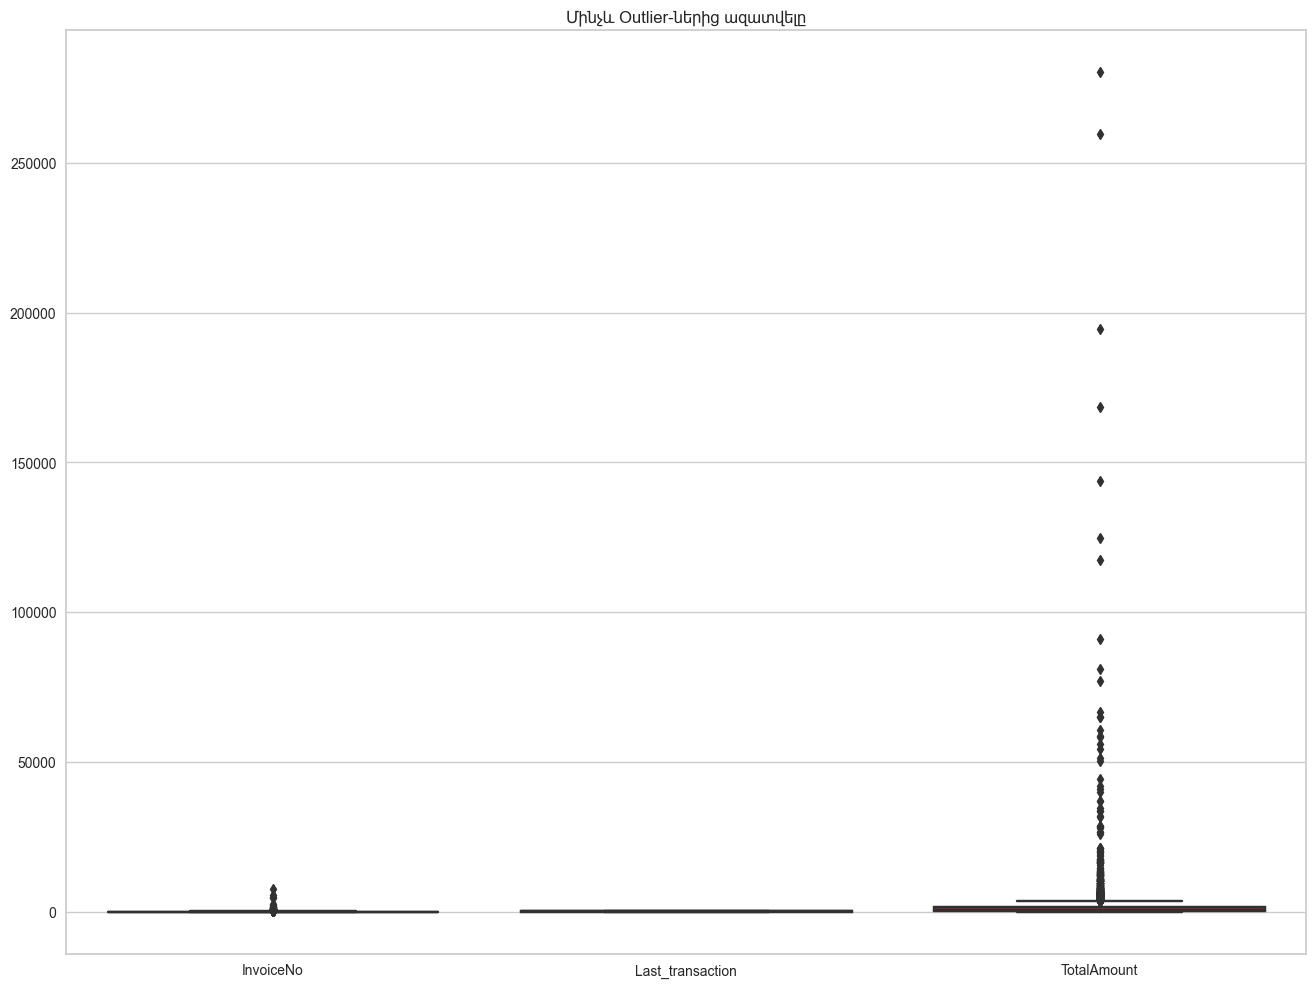

In [82]:
#Այժմ ազատվենք OutLier-ներից

plt.figure(figsize=(16,12))
sns.boxplot(data = new_df[['InvoiceNo','Last_transaction','TotalAmount']])
plt.title("Մինչև Outlier-ներից ազատվելը")
plt.show()


In [83]:
IQR= new_df['TotalAmount'].quantile(0.75)-new_df['TotalAmount'].quantile(0.25)
lower_limit= new_df['TotalAmount'].quantile(0.25) - 1.5*IQR
upper_limit=new_df['TotalAmount'].quantile(0.75) + 1.5*IQR
k=new_df[new_df['TotalAmount'] > upper_limit]
m=new_df[new_df['TotalAmount']<lower_limit]
df_iqr=new_df[(new_df['TotalAmount']<upper_limit) & (new_df['TotalAmount'] >lower_limit)]
print('Մինչև outlier-ներից ազատվելը:',new_df.shape)
print('Outlier-ներից ազատվելուց հետո:',df_iqr.shape)
print('Ընդհանուր Outlier-ների քանակը:',len(k)+len(m))

df_iqr.reset_index(drop=True, inplace= True)
new_df = df_iqr

Մինչև outlier-ներից ազատվելը: (4347, 5)
Outlier-ներից ազատվելուց հետո: (3923, 5)
Ընդհանուր Outlier-ների քանակը: 424


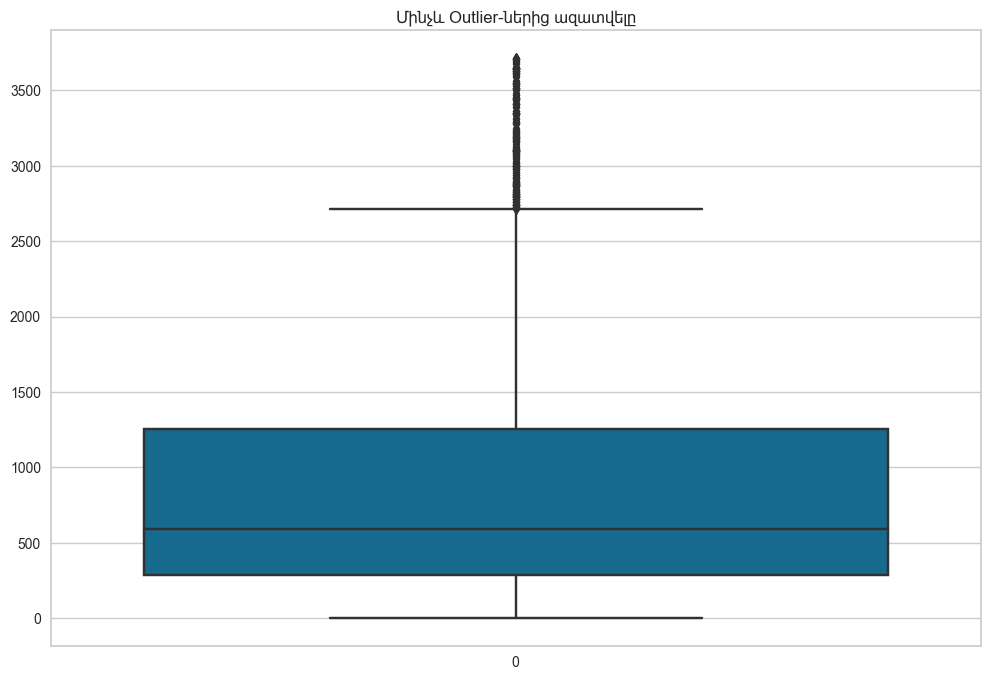

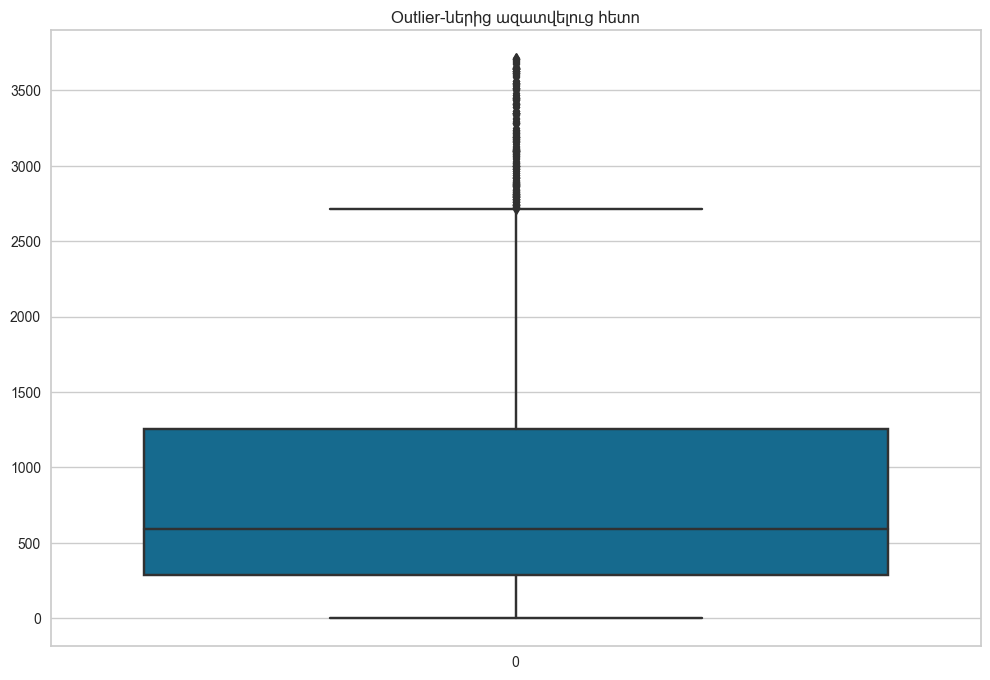

In [84]:
plt.figure(figsize=(12,8))
sns.boxplot(new_df['TotalAmount'])
plt.title('Մինչև Outlier-ներից ազատվելը')
plt.show()

plt.figure(figsize=(12,8))
sns.boxplot([df_iqr['TotalAmount']])
plt.title('Outlier-ներից ազատվելուց հետո')
plt.show()

In [85]:
new_df

,CustomerID,Country,Last_transaction,InvoiceNo,TotalAmount
0,12348.0,Finland,357,31,1797.24
1,12349.0,Italy,18,73,1757.55
2,12350.0,Norway,309,17,334.40
3,12352.0,Norway,296,85,2506.04
4,12353.0,Bahrain,203,4,89.00
...,...,...,...,...,...
3918,18280.0,United Kingdom,277,10,180.60
3919,18281.0,United Kingdom,180,7,80.82
3920,18282.0,United Kingdom,125,12,178.05
3921,18283.0,United Kingdom,336,756,2094.88


c:\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Python310\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


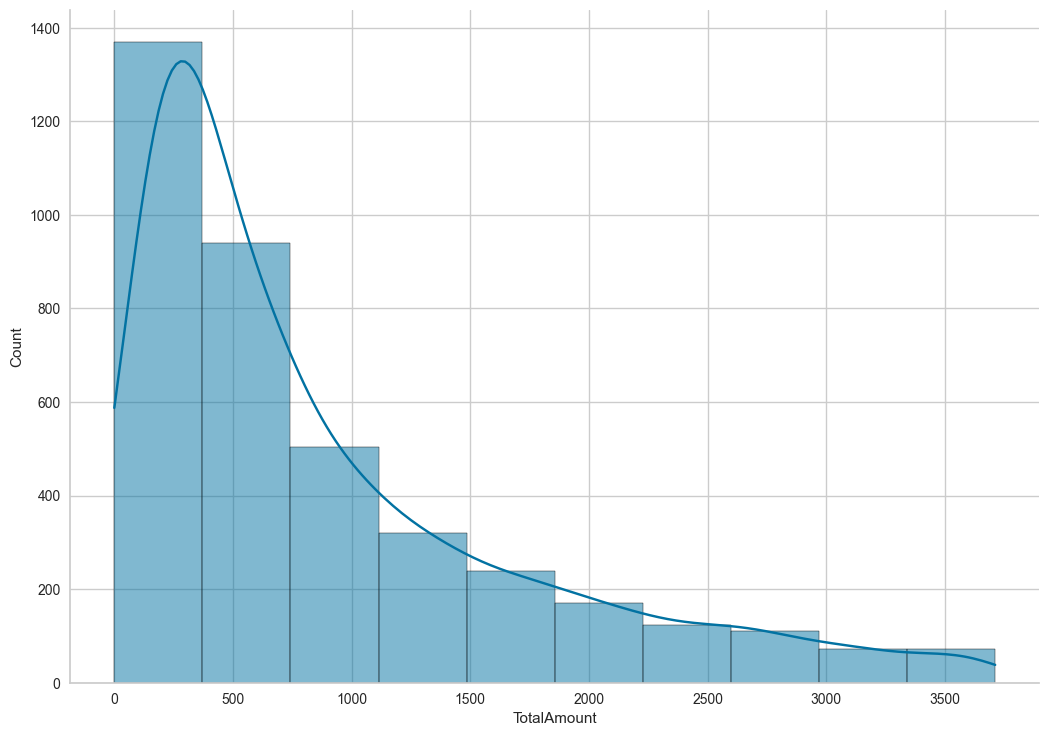

c:\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Python310\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


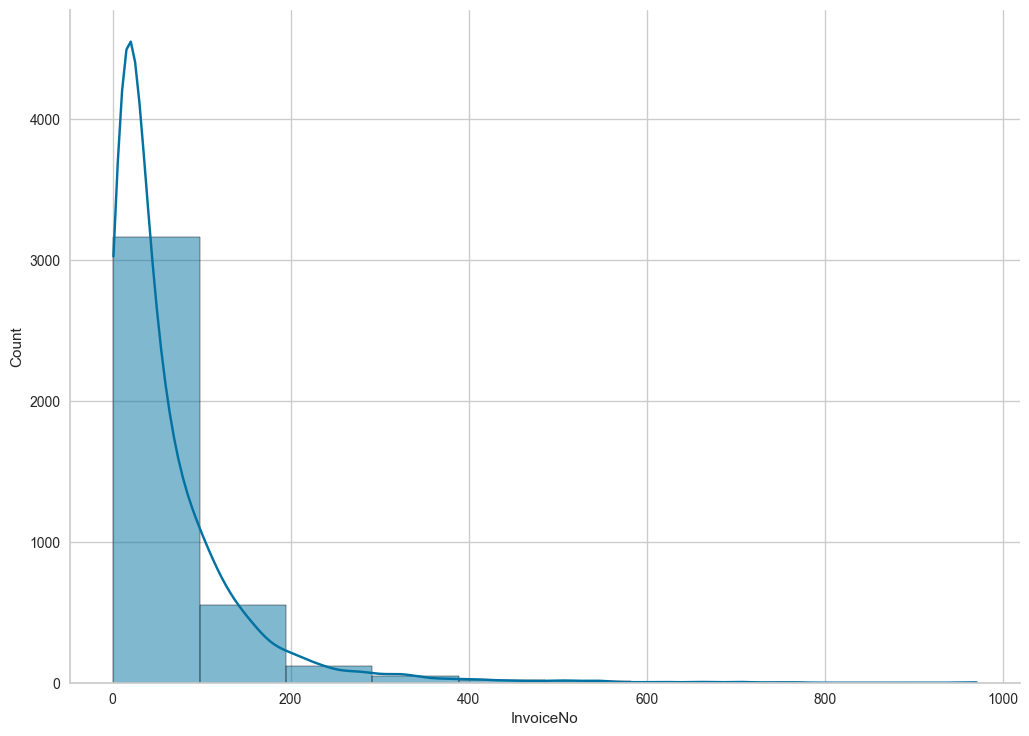

c:\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Python310\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


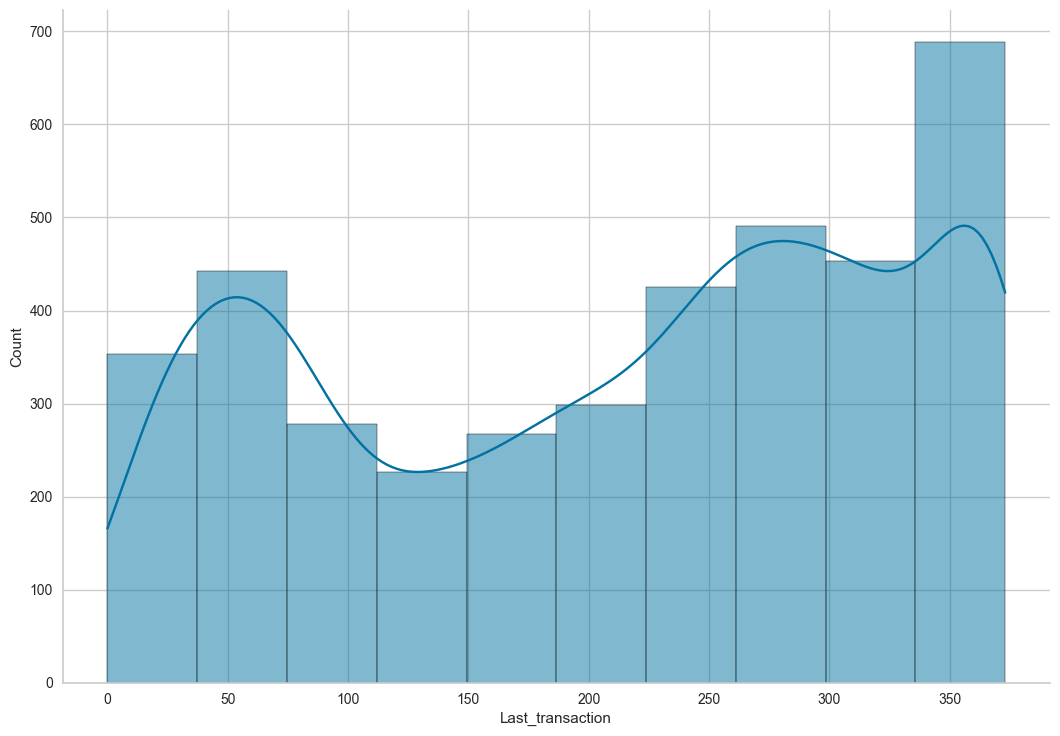

In [86]:
#Գծեքն Frequency Histogram-ները և KDE
df_num=['TotalAmount','InvoiceNo','Last_transaction']
for i in df_num:
    sns.displot(new_df[i],bins=10,kde=True)
    plt.gcf().set_size_inches(12, 8)
    plt.show()

In [87]:
#Histogram-ներից հասկացանք որ TotalAmount և InvoiceNo սյունեևը աջ սեղմված են իսկ Last_Transaction-ը Bimodal է

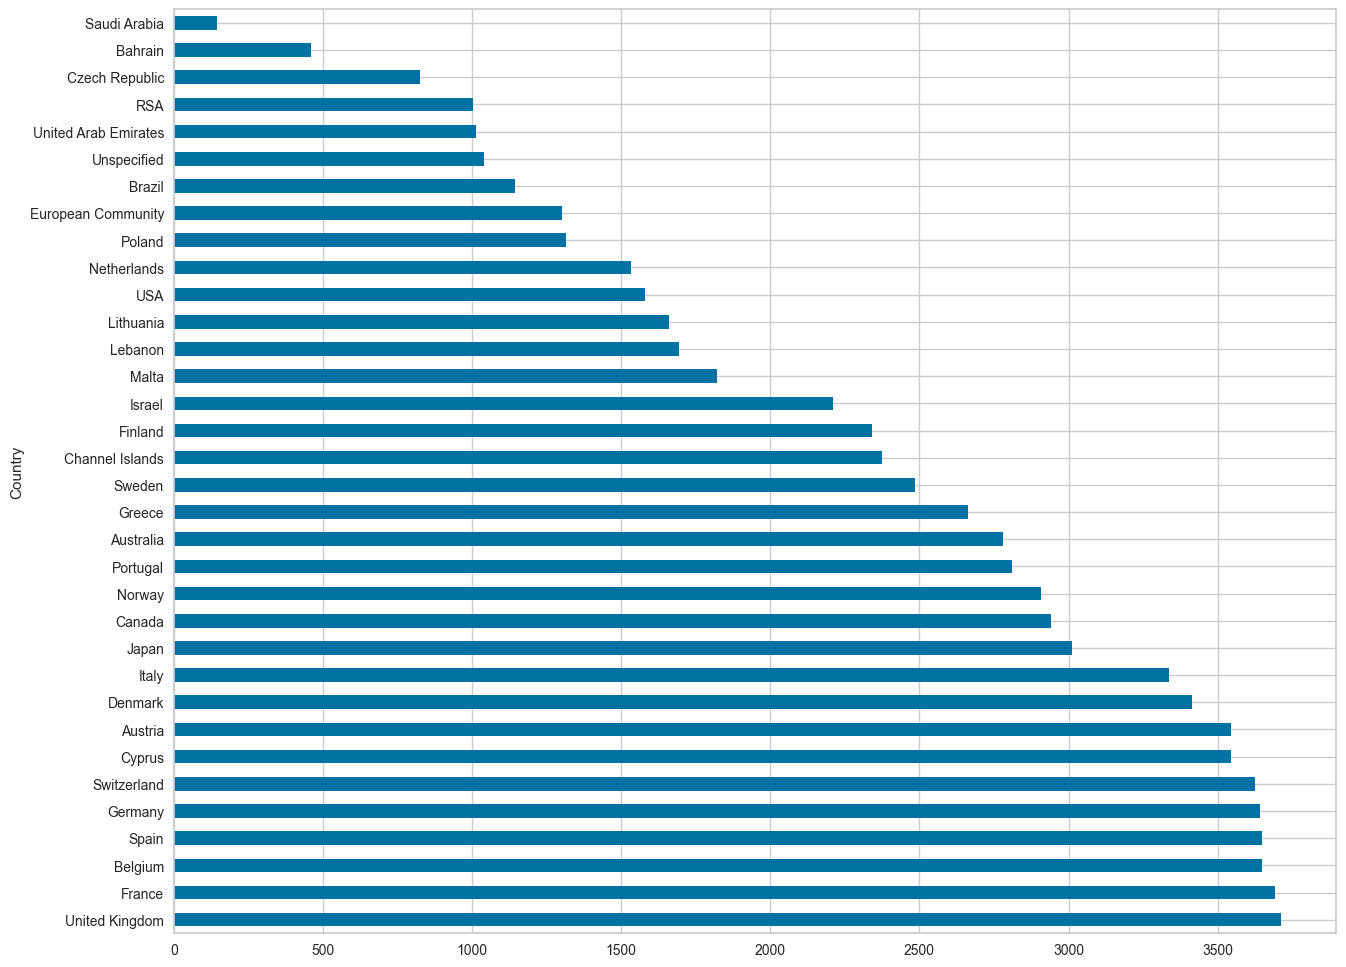

In [88]:
#Այստեղ խմբաորել ենք մաքսիմում Total_Amount-ը ըստ Country սյան

plt.figure(figsize=(15,12))
new_df.groupby("Country").TotalAmount.max().sort_values(ascending=False).plot.barh()
plt.show()

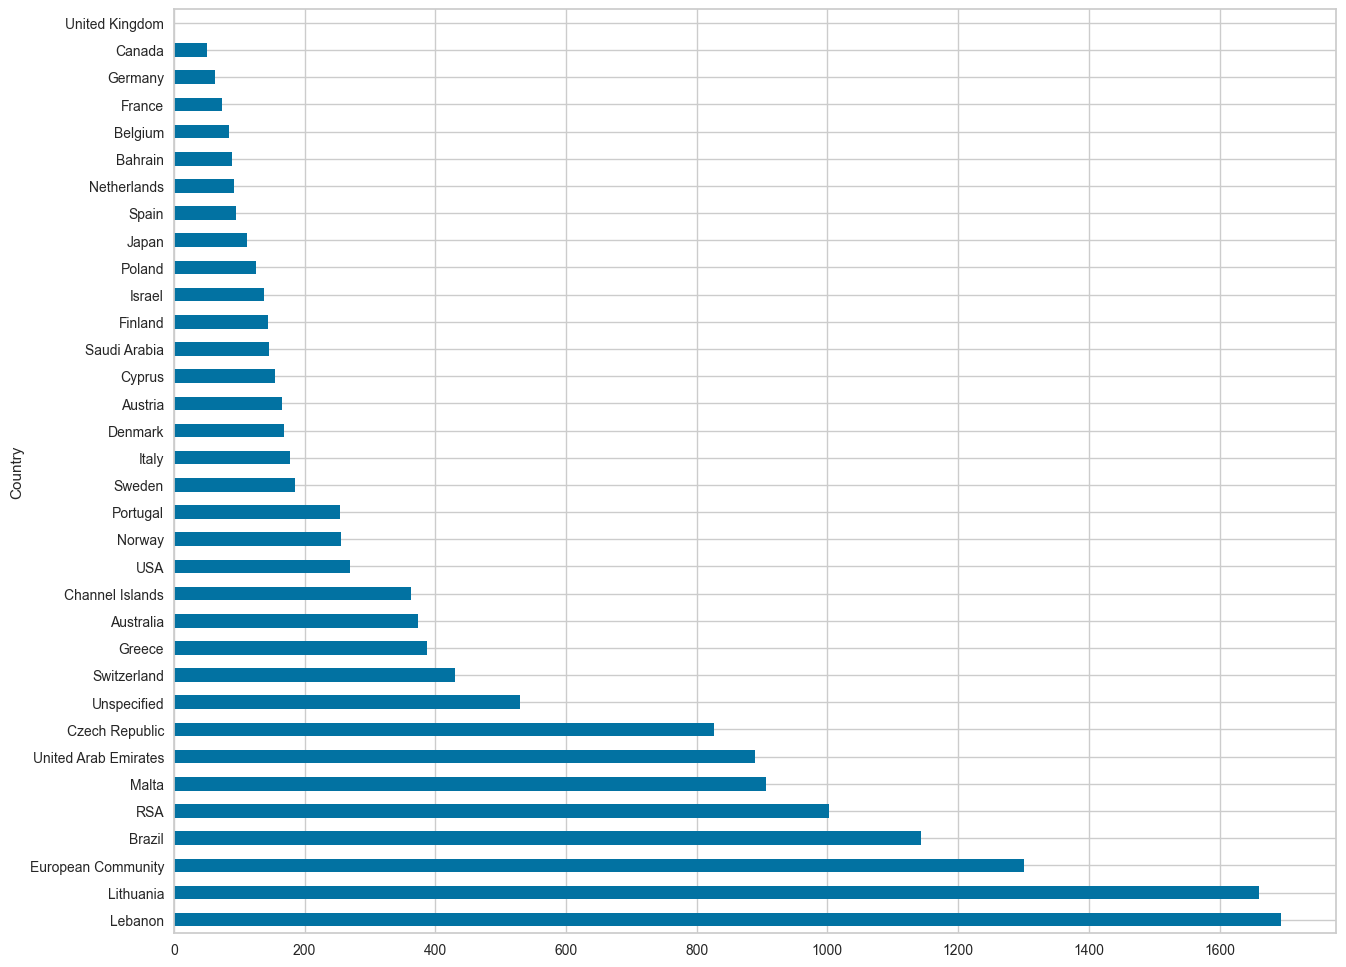

In [89]:
#Այստեղ խմբաորել ենք մինիմում Total_Amount-ը ըստ Country սյան

plt.figure(figsize=(15,12))
new_df.groupby("Country").TotalAmount.min().sort_values(ascending=False).plot.barh()
plt.show()

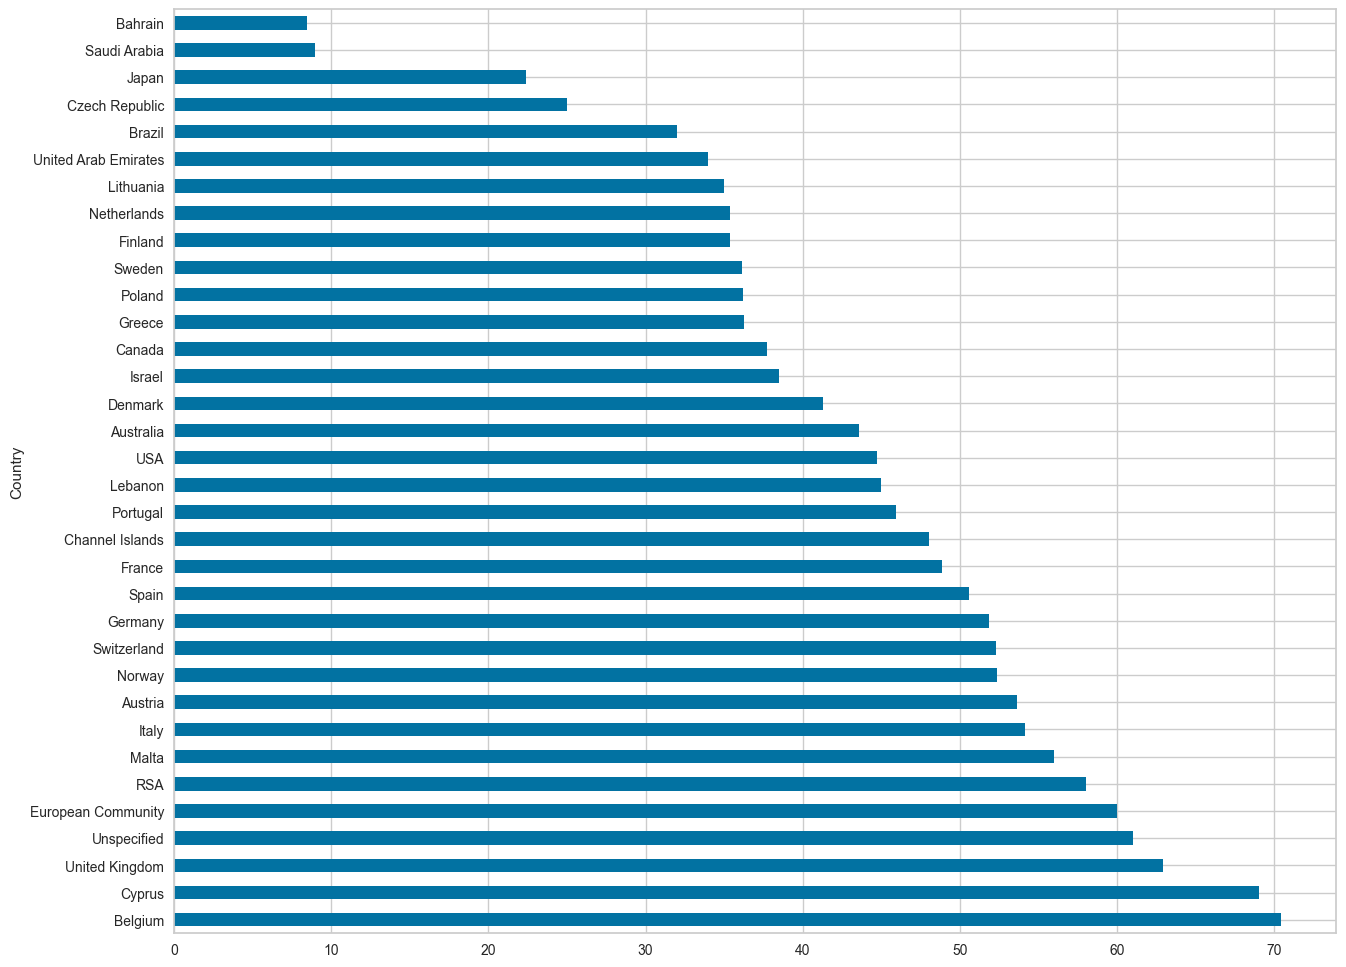

In [90]:
#Այստեղ երեվում է ամեն Country-ին համապատասխանող InvoiceNo-ի միջին քանակը, այսինքն ամեն երկրից միջինում գնված ապրանքների քանակը
plt.figure(figsize=(15,12))
new_df.groupby("Country").InvoiceNo.mean().sort_values(ascending=False).plot.barh()
plt.show()

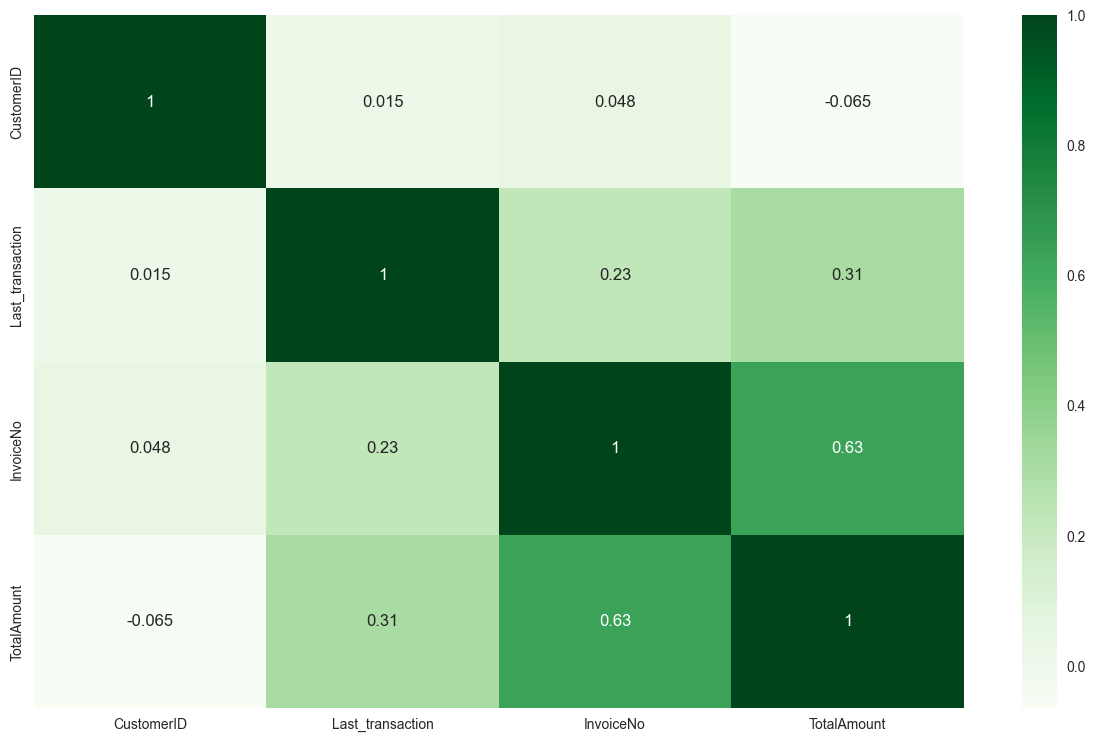

In [91]:
#հասկանանք թե որ սյուներն են կոռելացված
new_df1 = new_df.drop("Country", axis = 1)
plt.figure(figsize=(15,9))
sns.heatmap(new_df1.corr(),cmap="Greens", annot=True)
plt.show()


c:\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf

<Figure size 1500x800 with 0 Axes>

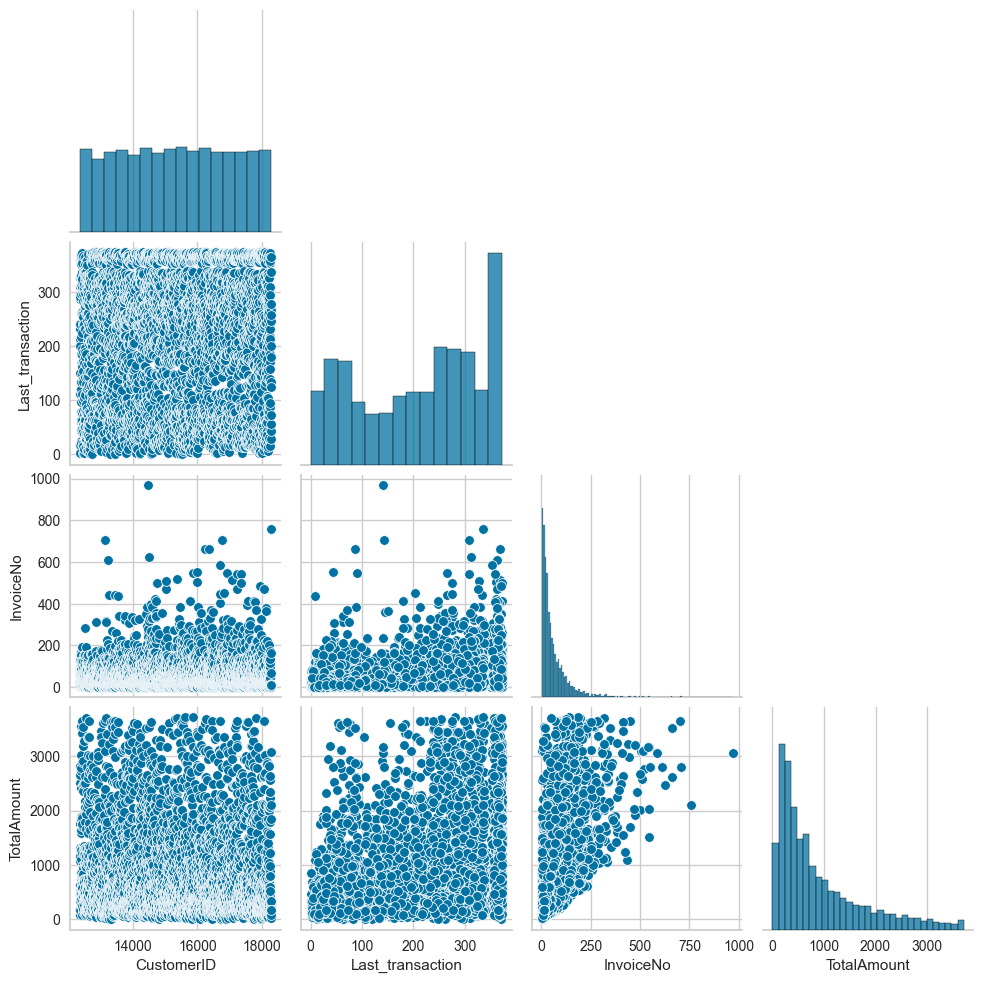

In [92]:
plt.figure(figsize=(15,8))
sns.pairplot(new_df1, corner=True)
plt.show()

In [93]:
new2_df=new_df[['Last_transaction','InvoiceNo','TotalAmount']]
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(new2_df)
scaled_df = pd.DataFrame(scaled_df)
scaled_df.columns=['Last_transaction','InvoiceNo','TotalAmount']
scaled_df['Country']=new_df['Country']
scaled_df

,Last_transaction,InvoiceNo,TotalAmount,Country
0,0.957105,0.030960,0.484200,Finland
1,0.048257,0.074303,0.473507,Italy
2,0.828418,0.016512,0.090092,Norway
3,0.793566,0.086687,0.675160,Norway
4,0.544236,0.003096,0.023978,Bahrain
...,...,...,...,...
3918,0.742627,0.009288,0.048656,United Kingdom
3919,0.482574,0.006192,0.021774,United Kingdom
3920,0.335121,0.011352,0.047969,United Kingdom
3921,0.900804,0.779154,0.564388,United Kingdom


      Last_transaction  InvoiceNo  TotalAmount
0             0.957105   0.030960     0.484200
1             0.048257   0.074303     0.473507
2             0.828418   0.016512     0.090092
3             0.793566   0.086687     0.675160
4             0.544236   0.003096     0.023978
...                ...        ...          ...
3918          0.742627   0.009288     0.048656
3919          0.482574   0.006192     0.021774
3920          0.335121   0.011352     0.047969
3921          0.900804   0.779154     0.564388
3922          0.538874   0.071207     0.494988

[3923 rows x 3 columns]


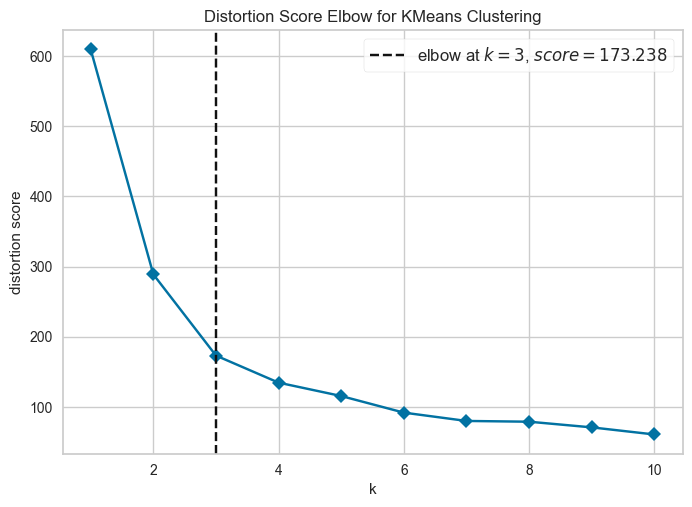

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [94]:
data_for_clustering = scaled_df.drop('Country', axis= 1)
print(data_for_clustering)
# Elbow Method for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(1,11), timings= False)
visualizer.fit(data_for_clustering)        # Fit data to visualizer
visualizer.show() 

In [95]:
K_data = data_for_clustering.copy()
km = KMeans(n_clusters=3)
y_predicted = km.fit_predict(K_data)
K_data['clusters']= y_predicted
print(K_data)
print("Center of Clusters:",km.cluster_centers_)


      Last_transaction  InvoiceNo  TotalAmount  clusters
0             0.957105   0.030960     0.484200         0
1             0.048257   0.074303     0.473507         2
2             0.828418   0.016512     0.090092         1
3             0.793566   0.086687     0.675160         0
4             0.544236   0.003096     0.023978         1
...                ...        ...          ...       ...
3918          0.742627   0.009288     0.048656         1
3919          0.482574   0.006192     0.021774         2
3920          0.335121   0.011352     0.047969         2
3921          0.900804   0.779154     0.564388         0
3922          0.538874   0.071207     0.494988         0

[3923 rows x 4 columns]
Center of Clusters: [[0.79802009 0.15828192 0.63429608]
 [0.77682734 0.04291209 0.15787234]
 [0.2209531  0.04001379 0.14854249]]


C:\Users\Robert\AppData\Local\Temp\ipykernel_16512\2982371871.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new2_df['clusters']= y_predicted


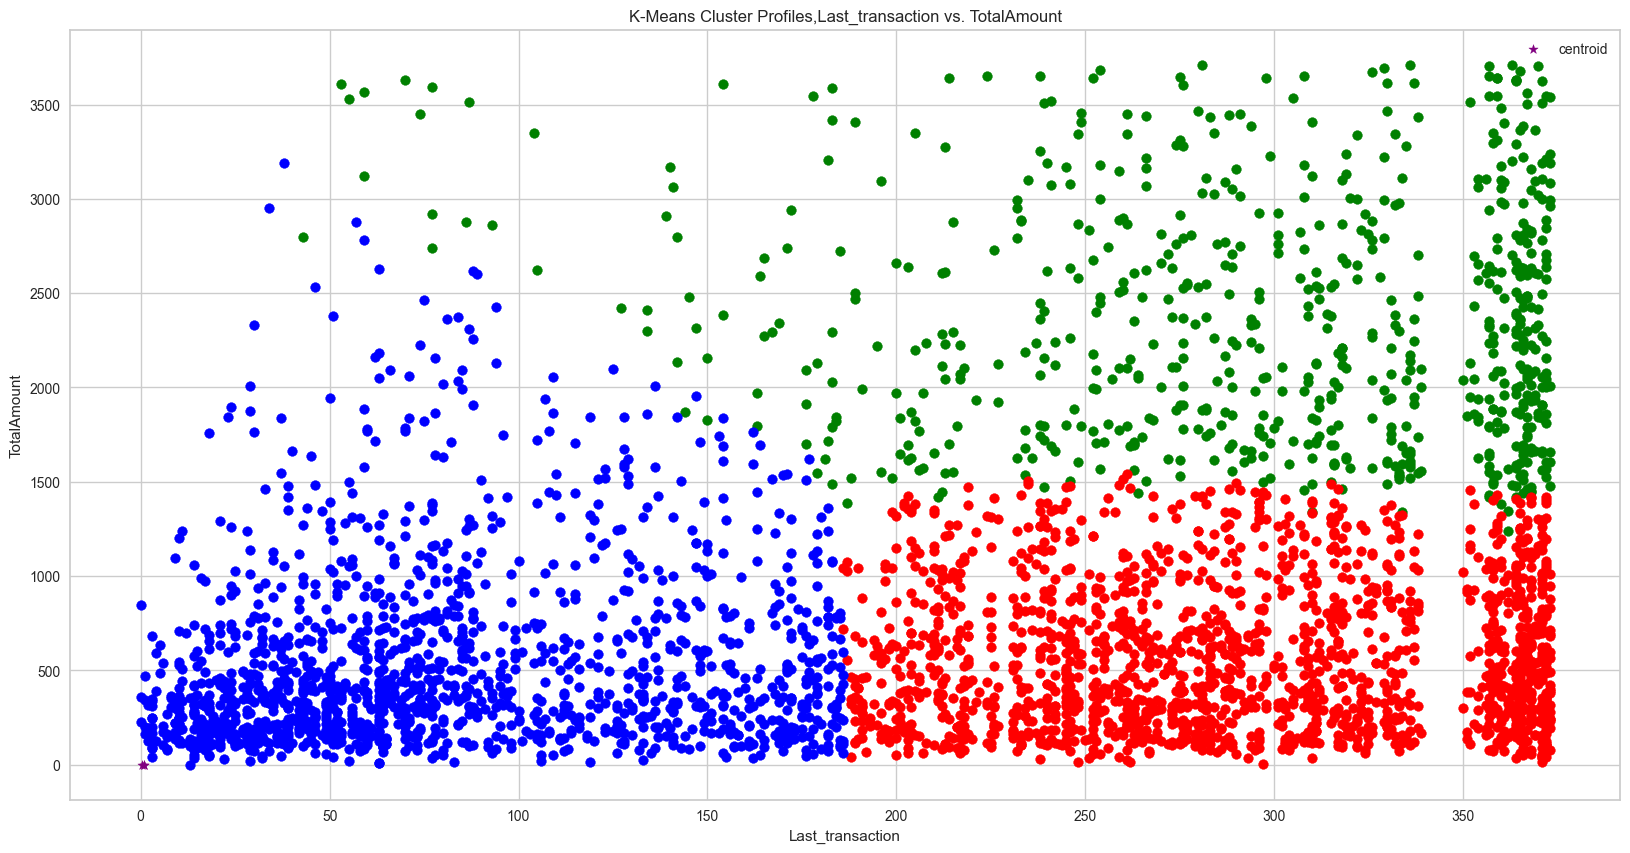

In [96]:
# Visualize the clusters with original data
new2_df['clusters']= y_predicted
df1 = new2_df[new2_df.clusters==0]
df2 = new2_df[new2_df.clusters==1]
df3 = new2_df[new2_df.clusters==2]
plt.figure(figsize=(20,10))
plt.scatter(df1.Last_transaction,df1['TotalAmount'],color='green')
plt.scatter(df2.Last_transaction,df2['TotalAmount'],color='red')
plt.scatter(df3.Last_transaction,df3['TotalAmount'],color='blue')
plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],color='purple',marker='*',label='centroid')
plt.legend()
plt.xlabel('Last_transaction')
plt.ylabel('TotalAmount')
plt.title('K-Means Cluster Profiles,Last_transaction vs. TotalAmount')
plt.show()

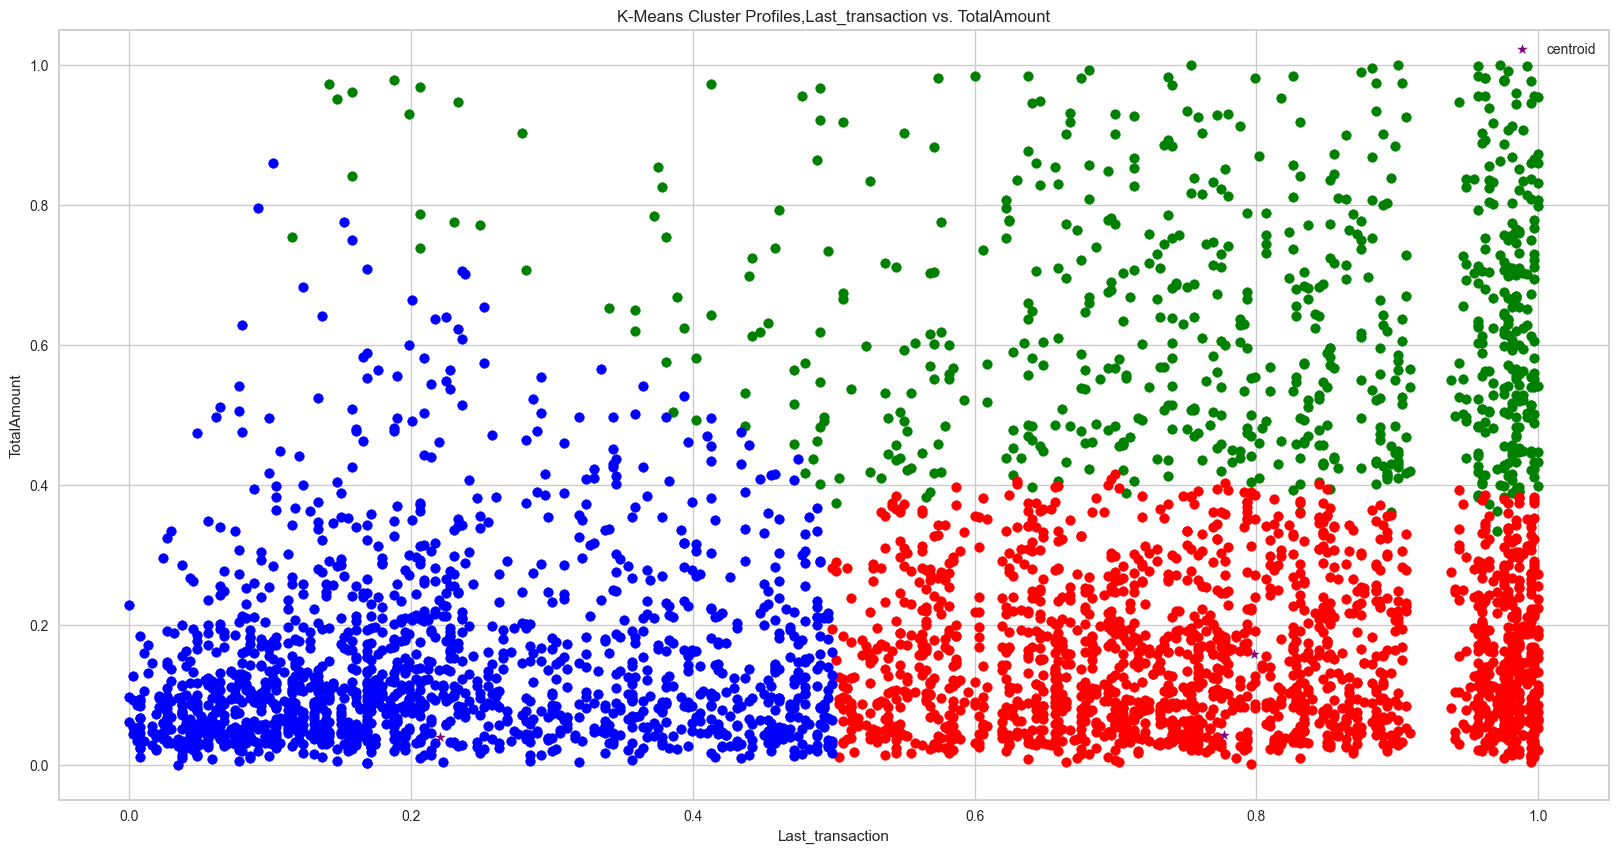

In [97]:
# Visualize the clusters with scaled data:
df1 = K_data[K_data.clusters==0]
df2 = K_data[K_data.clusters==1]
df3 = K_data[K_data.clusters==2]
plt.figure(figsize=(20,10))
plt.scatter(df1.Last_transaction,df1['TotalAmount'],color='green')
plt.scatter(df2.Last_transaction,df2['TotalAmount'],color='red')
plt.scatter(df3.Last_transaction,df3['TotalAmount'],color='blue')
plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],color='purple',marker='*',label='centroid')
plt.legend()
plt.xlabel('Last_transaction')
plt.ylabel('TotalAmount')
plt.title('K-Means Cluster Profiles,Last_transaction vs. TotalAmount')
plt.show()

Text(0.5, 0.92, 'K Means')

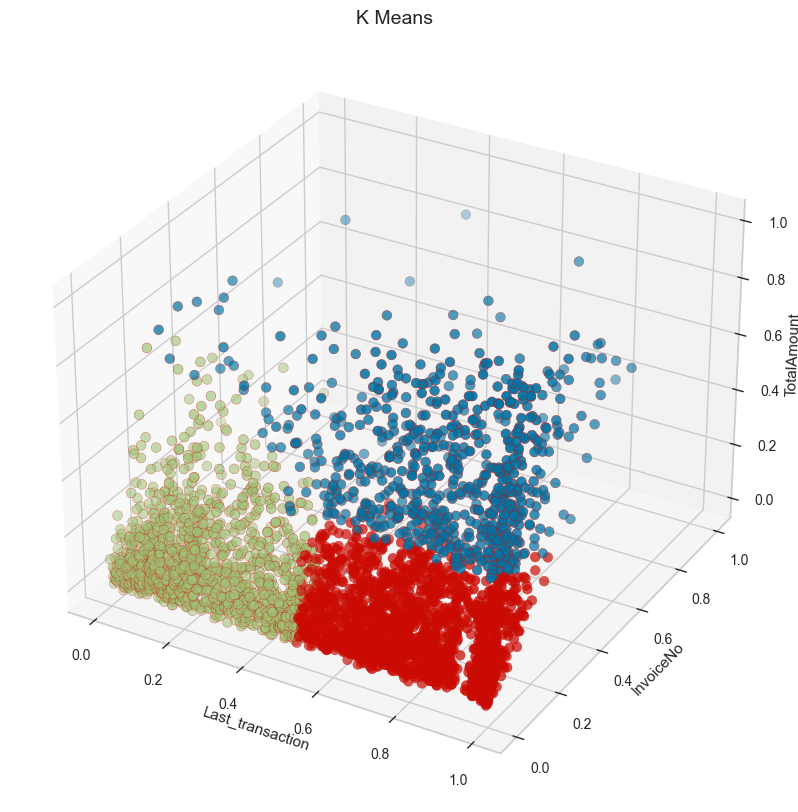

In [98]:

from matplotlib.colors import ListedColormap
cmap = ListedColormap(['r', 'g', 'b']) 
# Assuming data_for_clustering is your DataFrame containing the data

# KMeans Clustering
km = KMeans(n_clusters=3)
km.fit(K_data)
km.predict(K_data)
labels = km.labels_
#Plotting
fig = plt.figure(1, figsize=(20,10))
ax = fig.add_subplot(111, projection= '3d')
ax.scatter(K_data['Last_transaction'], 
           K_data['InvoiceNo'], 
           K_data['TotalAmount'],
          c=labels.astype(np.float64), 
           edgecolor="r", s=50, cmap = cmap)
ax.set_xlabel("Last_transaction")
ax.set_ylabel("InvoiceNo")
ax.set_zlabel("TotalAmount")
plt.title("K Means", fontsize=14)

C:\Users\Robert\AppData\Local\Temp\ipykernel_16512\1586810065.py:56: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(K, S, 'bo-', color='black')


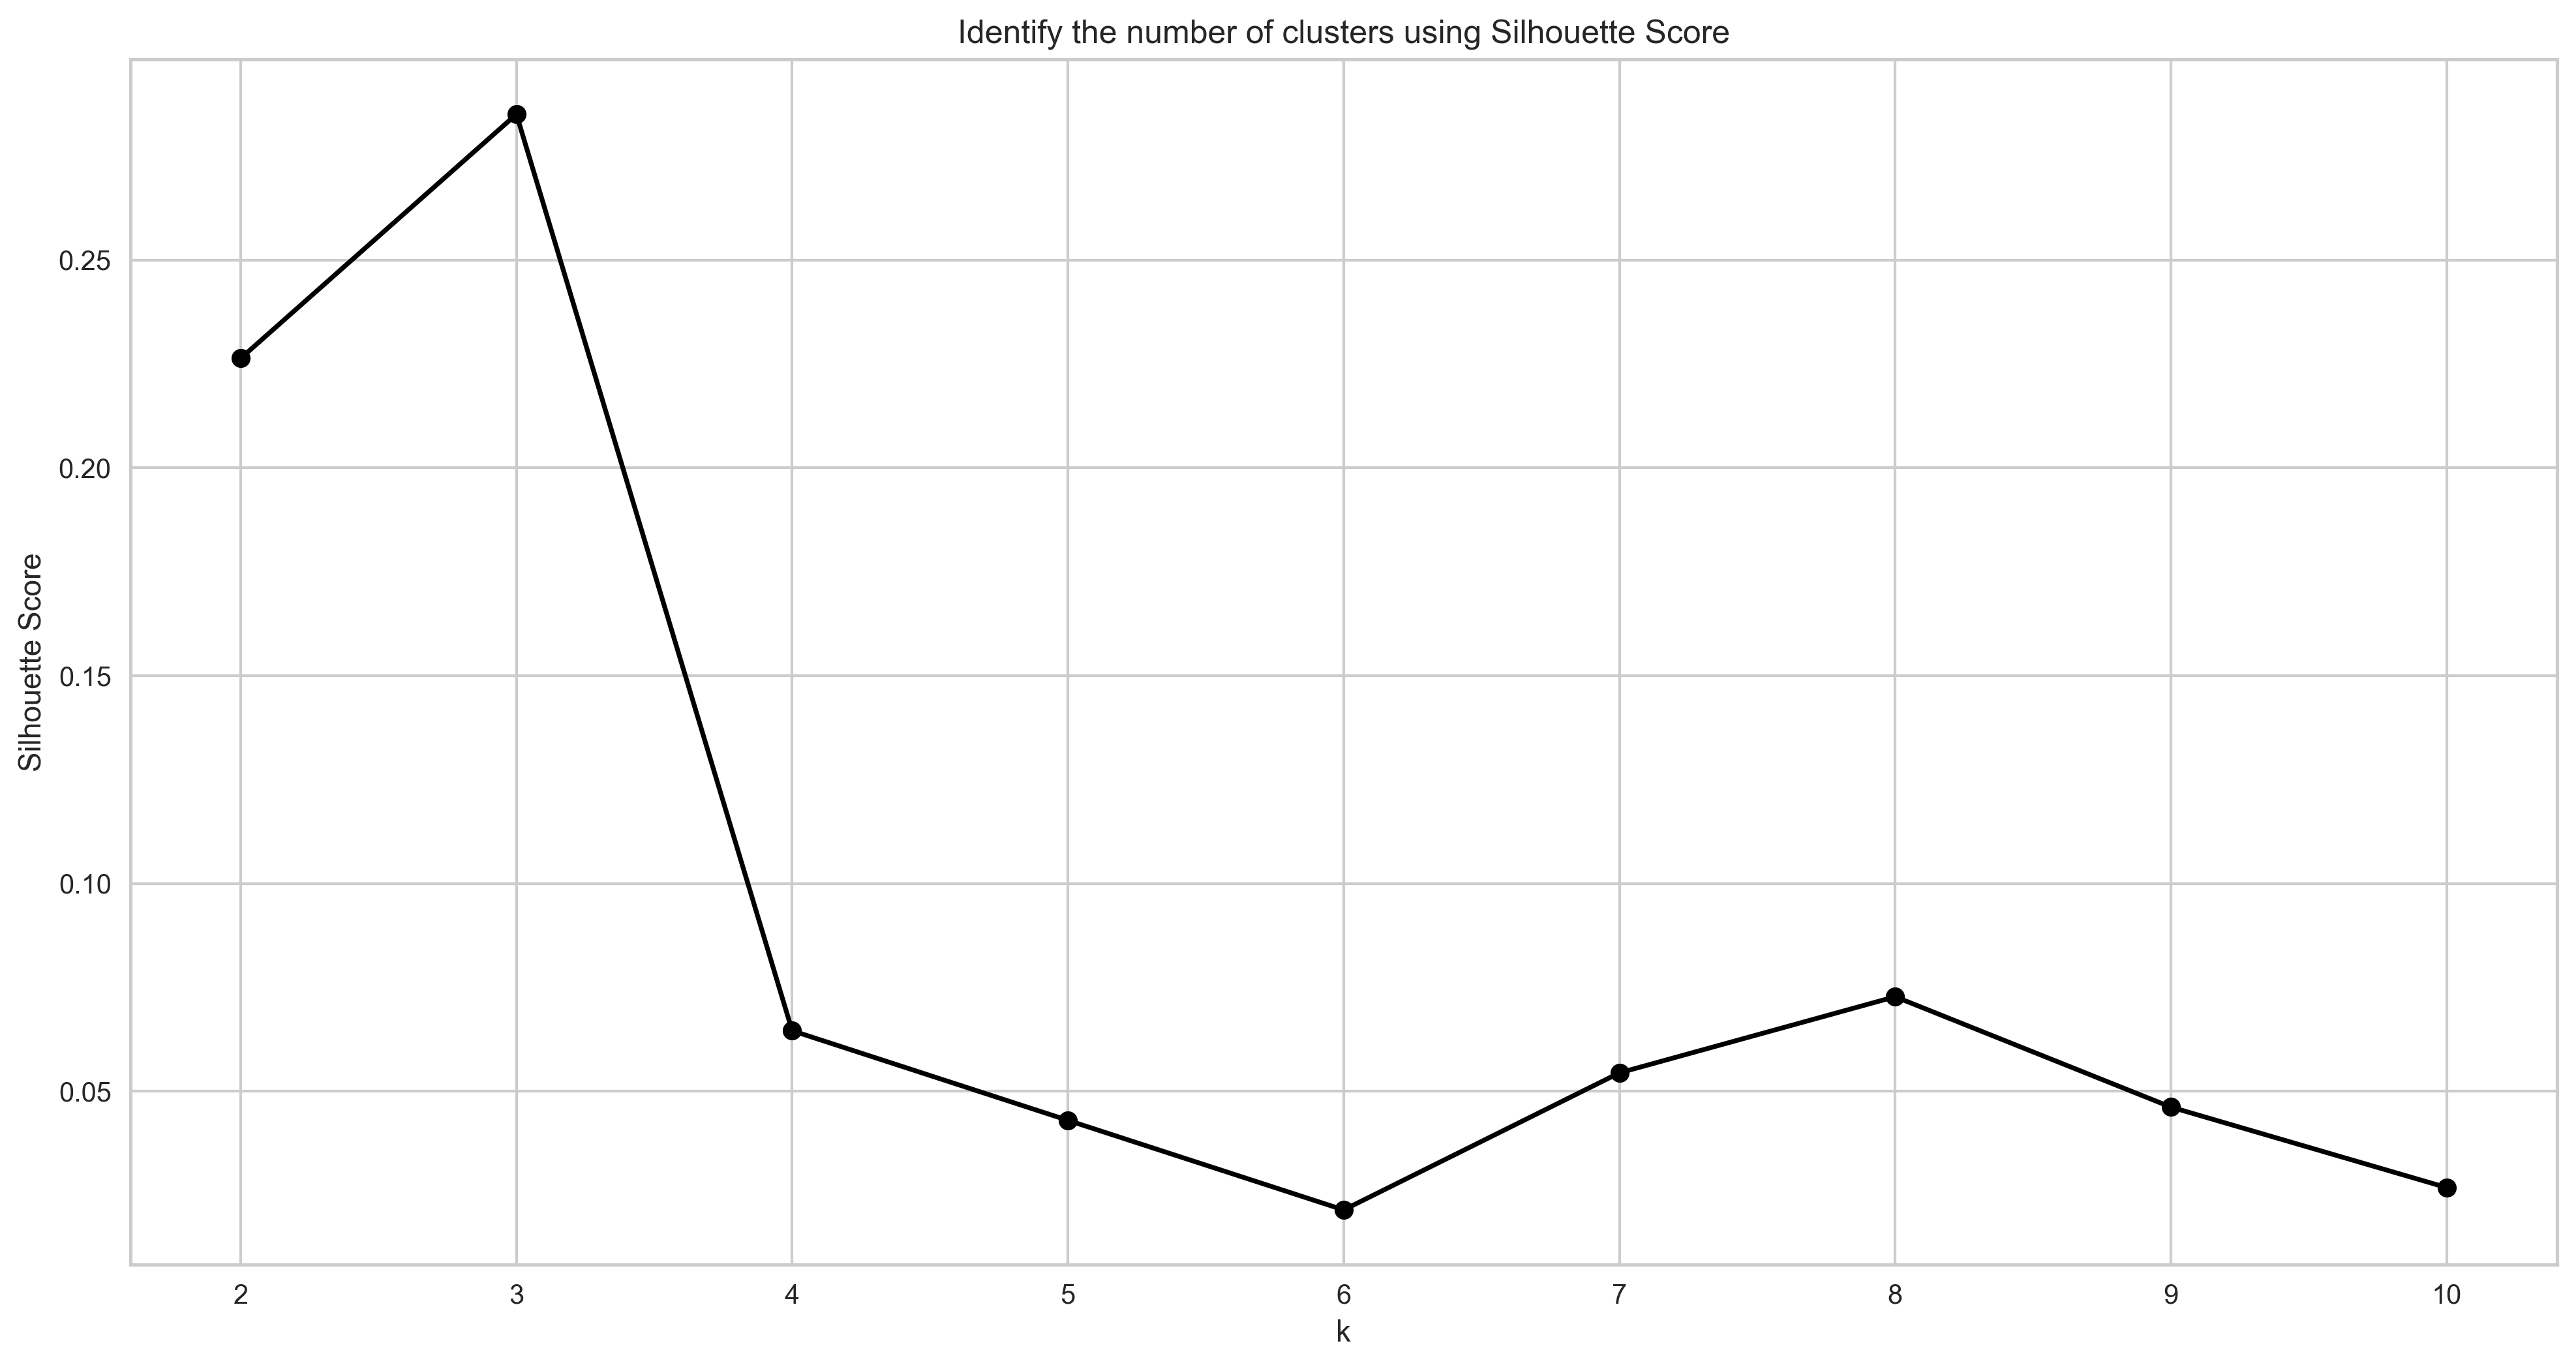

In [111]:




S=[]

# Range of clusters to try (2 to 10)
K=range(2,11)

# Select data for clustering model
X = data_for_clustering.copy()

for k in K:
    # Set the model and its parameters
    model = GaussianMixture(n_components=k, n_init=20, init_params='kmeans')
    # Fit the model 
    labels = model.fit_predict(X)
    # Calculate Silhoutte Score and append to a list
    S.append(metrics.silhouette_score(X, labels, metric='euclidean'))

# Plot the resulting Silhouette scores on a graph
plt.figure(figsize=(16,8), dpi=300)
plt.plot(K, S, 'bo-', color='black')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Identify the number of clusters using Silhouette Score')
plt.show()

      Last_transaction  InvoiceNo  TotalAmount  Cluster
2             0.828418   0.016512     0.090092        2
4             0.544236   0.003096     0.023978        2
5             0.619303   0.058824     0.290805        2
6             0.571046   0.012384     0.123768        2
10            0.766756   0.009288     0.051162        2
...                ...        ...          ...      ...
3911          0.713137   0.010320     0.076284        2
3913          0.689008   0.002064     0.054960        2
3918          0.742627   0.009288     0.048656        2
3919          0.482574   0.006192     0.021774        2
3920          0.335121   0.011352     0.047969        2

[1587 rows x 4 columns]


Text(0.5, 0.92, 'Gaussian Mixture Model')

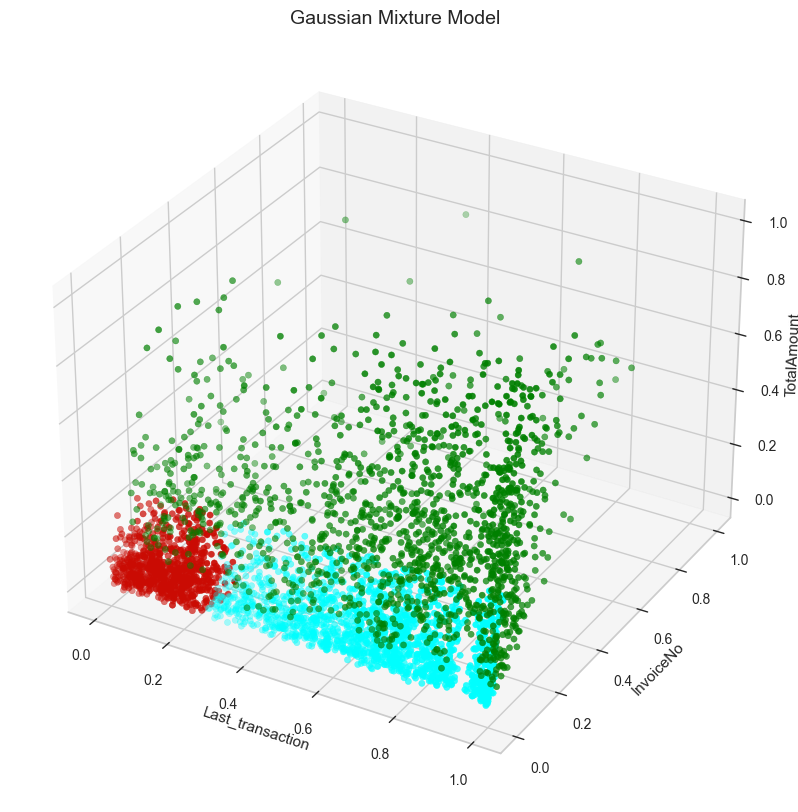

In [112]:

gmm = GaussianMixture(n_components=3)
gmm.fit(data_for_clustering)
proba_lists = gmm.predict_proba(data_for_clustering)
#Plotting
a = gmm.predict(data_for_clustering)
new_data11 = data_for_clustering.copy()
new_data11['Cluster'] = a
df1 = new_data11[new_data11.Cluster == 0]
df2 = new_data11[new_data11.Cluster == 1]
df3 = new_data11[new_data11.Cluster == 2]


# plt.scatter(df1.Last_transaction,df1['TotalAmount'],color='green')
print(df3)
# colored_arrays = np.matrix(proba_lists)
# colored_tuples = [tuple(i.tolist()[0]) for i in colored_arrays]
# print(colored_tuples)
fig = plt.figure(1, figsize=(20,10))
ax = fig.add_subplot(111, projection= '3d')
ax.scatter(df1['Last_transaction'], df1['InvoiceNo'], df1['TotalAmount'], color = 'r')
ax.scatter(df2['Last_transaction'], df2['InvoiceNo'], df2['TotalAmount'], color = 'green')
ax.scatter(df3['Last_transaction'], df3['InvoiceNo'], df3['TotalAmount'], color = 'cyan')
ax.set_xlabel("Last_transaction")
ax.set_ylabel("InvoiceNo")
ax.set_zlabel("TotalAmount")
plt.title("Gaussian Mixture Model", fontsize=14)